In [1]:
import sys
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import sumolib
import traci
from sumolib import checkBinary
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch
import sys
import io
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from collections import namedtuple, deque
import gym
from torch_geometric.utils import dense_to_sparse
import copy
from itertools import count

if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))

# sumoBinary = checkBinary('sumo-gui')
sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("Using device: " + str(device))

SUMO_HOME found
Using device: cuda


In [2]:
def intervehicleConnectivity(threshold = None):
    xs = []
    ys = []
    for vehicle in traci.vehicle.getIDList():
        x, y = traci.vehicle.getPosition(vehicle)
        xs.append(x)
        ys.append(y)
    xs = torch.tensor(xs, dtype=torch.float32).view(-1,1)
    ys = torch.tensor(ys, dtype=torch.float32).view(-1,1)
    intervehicle_distances = torch.sqrt((xs - xs.t())**2 + (ys - ys.t())**2)
    if threshold is not None:
        # make the distances 1 if less than the threshold, 0 otherwise
        connectivity = torch.where(intervehicle_distances < threshold, torch.ones_like(intervehicle_distances), torch.zeros_like(intervehicle_distances))
    assert connectivity.shape[0] == intervehicle_distances.shape[0]
    return connectivity

In [3]:
def randomTrips(dur=1000, density=12):
    os.system("python $SUMO_HOME/tools/randomTrips.py -n config/osm.net.xml.gz -r config/osm.passenger.trips.xml -e " + str(dur) + " -l --insertion-density=" + str(density))

def shouldContinueSim():
    numVehicles = traci.simulation.getMinExpectedNumber()
    return True if numVehicles > 0 else False

def restart(sumoCmd):
    with io.StringIO() as buf, redirect_stdout(buf):
        try:
            traci.close()
        except:
            pass
        traci.start(sumoCmd)

def close():
    traci.close()

randomTrips(800, 1.5)

Success.


In [4]:
def bfs_distance(adj_matrix):
    n_hop_matrix = torch.ones_like(adj_matrix) * 100
    for start_node in range(adj_matrix.size(0)):
        visited = [0] * adj_matrix.size(0)
        queue = deque([(start_node, 0)])
        visited[start_node] = True
        
        while queue:
            current_node, current_dist = queue.popleft()
            
            for neighbor, connected in enumerate(adj_matrix[current_node]):
                if connected and not visited[neighbor]:
                    queue.append((neighbor, current_dist + 1))
                    visited[neighbor] = True
                    n_hop_matrix[start_node, neighbor] = current_dist + 1
    return n_hop_matrix

## Node Degrees Before Pruning

In [5]:
restart(sumoCmd)
max_action_spaces = []
total_actions = 0

total_missing_gain = 0
total_delay_gain = 0
step = 0


while shouldContinueSim():
    step += 1
    if step > 1100:
        close()
        break
    traci.simulationStep()
    if step < 400:
        continue
    ids = traci.vehicle.getIDList()
    connectivity = intervehicleConnectivity(800)
    # minus the diagonal
    action_spaces = connectivity.to("cpu") - torch.eye(connectivity.size(0))
    for i, vehicle in enumerate(ids):
        # get non-zero indices except the diagonal
        non_zero_indices = np.where(action_spaces[i] == 1)[0]
        max_action_spaces.append(len(non_zero_indices))

# print each action space's proportion
cumulative = 0
cumulative_list = []
prob_list = []
for i in list(set(sorted(max_action_spaces, reverse=True))):
    prob_list.append(max_action_spaces.count(i)/len(max_action_spaces))
    print(prob_list[-1])
    cumulative += max_action_spaces.count(i)/len(max_action_spaces)
    cumulative_list.append(cumulative)
    print(cumulative)

***Starting server on port 54159 ***
Loading net-file from './config/osm.net.xml.gz' ... done (102ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Simulation ended at time: 1100.00
Reason: TraCI requested termination.
Performance: 
 Duration: 1.60s
 TraCI-Duration: 1.40s
 Real time factor: 688.36
 UPS: 25515.018773
Vehicles: 
 Inserted: 89
 Running: 31
 Waiting: 0
Statistics (avg of 58):
 RouteLength: 4086.67
 Speed: 9.55
 Duration: 436.98
 WaitingTime: 14.81
 TimeLoss: 59.12
 DepartDelay: 0.47

0.10609013021558257
0.10609013021558257
0.15758869196746156
0.2636788221830441
0.14970152485230892
0.41338034703535304
0.12053447155980329
0.5339148185951563
0.1150598496798738
0.6489746682750301
0.08332560081655377
0.7323002690915839
0.052333673564071634
0.7846339426556554
0.05848875692060252
0.843122699576258
0.046797191549905665
0.8899198911261637
0.03470353530667161
0.9246234264328352
0.022300578392255112
0.9469240048250903
0.017166187250626335
0.9640901920757167
0.0173

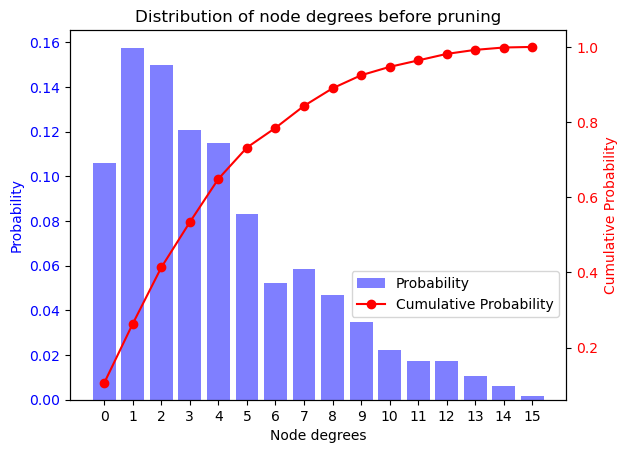

In [6]:
fig, ax1 = plt.subplots()

num_neighbour = [i for i in range(0, len(prob_list))]

ax1.bar(num_neighbour, prob_list, alpha=0.5, color='blue', label='Probability')
ax1.set_xlabel('Node degrees')

ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(num_neighbour)
# Step 4: Plot the cumulative probability curve
ax2 = ax1.twinx()
ax2.plot(num_neighbour, cumulative_list, color='red', marker='o', linestyle='-', label='Cumulative Probability')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_ylabel('Probability', color='blue')
ax2.set_ylabel('Cumulative Probability', color='red')
ax1.set_title('Distribution of node degrees before pruning')
fig.legend(loc=(0.56, 0.3))

plt.show()
# save as pdf
fig.savefig('before pruning.pdf', format='pdf', dpi=1200, bbox_inches='tight')

## Node Degrees After Pruning

In [7]:
def simplify_graph(adj_matrix):
    adj_matrix = adj_matrix - torch.eye(adj_matrix.size(0))
    degrees = torch.sum(adj_matrix, axis=0)
    nodes_to_keep = np.where(degrees > 0)[0]
    new_adj_matrix = adj_matrix[np.ix_(nodes_to_keep, nodes_to_keep)]
    return new_adj_matrix

In [13]:
restart(sumoCmd)
max_action_spaces = []
total_actions = 0

total_missing_gain = 0
total_delay_gain = 0
step = 0
max_num_nodes = 0


while shouldContinueSim():
    step += 1
    if step > 1100:
        close()
        break
    traci.simulationStep()
    if step < 400:
        continue
    adj_matrix = intervehicleConnectivity(800)
    adj_matrix = simplify_graph(adj_matrix)
    n_hop_matrix = bfs_distance(adj_matrix)
    # minus the diagonal
    adj_matrix = adj_matrix.to("cpu")
    
    for i in range(adj_matrix.size(0)):
        n_unreachable_nodes = len(torch.where(n_hop_matrix[i] == 100)[0])
        n_nodes = adj_matrix.size(0) - n_unreachable_nodes
        max_num_nodes = max(max_num_nodes, n_nodes)
        non_zero_indices = np.where(adj_matrix[i] == 1)[0]
        two_hop_neighbours = np.where(n_hop_matrix[i] == 2)[0]
        two_hop_neighbours_mask = (n_hop_matrix[i] == 2).type(torch.int)
        # direct neighbours connectivities with two hop neighbours
        neighbour_dict = {}
        for neighbour_index in non_zero_indices:
            neighbour_dict[neighbour_index] = two_hop_neighbours[np.where(adj_matrix[neighbour_index][two_hop_neighbours] == 1)[0]]
        # sort by the number of two hop neighbours
        neighbour_dict = dict(sorted(neighbour_dict.items(), key=lambda item: len(item[1]), reverse=True))
        
        action_space = 0
        to_remove_indices = []
        for neighbour_index, two_hop_neighbours_indices in neighbour_dict.items():
            mask_sum_before = torch.sum(two_hop_neighbours_mask)
            two_hop_neighbours_mask[two_hop_neighbours_indices] = 0
            mask_sum_after = torch.sum(two_hop_neighbours_mask)
            if mask_sum_after < mask_sum_before:
                action_space += 1
            else:
                to_remove_indices.append(neighbour_index)
        cur_adj_matrix = np.delete(adj_matrix, to_remove_indices, axis=0)
        cur_adj_matrix = np.delete(cur_adj_matrix, to_remove_indices, axis=1)
        max_action_spaces.append(action_space)

# print each action space's proportion
cumulative = 0
cumulative_list = []
prob_list = []
for i in list(set(sorted(max_action_spaces, reverse=True))):
    prob_list.append(max_action_spaces.count(i)/len(max_action_spaces))
    cumulative += max_action_spaces.count(i)/len(max_action_spaces)
    cumulative_list.append(cumulative)
print(max_num_nodes)

***Starting server on port 55719 ***
Loading net-file from './config/osm.net.xml.gz' ... done (106ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Simulation ended at time: 1100.00
Reason: TraCI requested termination.
Performance: 
 Duration: 27.27s
 TraCI-Duration: 26.91s
 Real time factor: 40.3329
 UPS: 1494.995050
Vehicles: 
 Inserted: 89
 Running: 31
 Waiting: 0
Statistics (avg of 58):
 RouteLength: 4086.67
 Speed: 9.55
 Duration: 436.98
 WaitingTime: 14.81
 TimeLoss: 59.12
 DepartDelay: 0.47

43


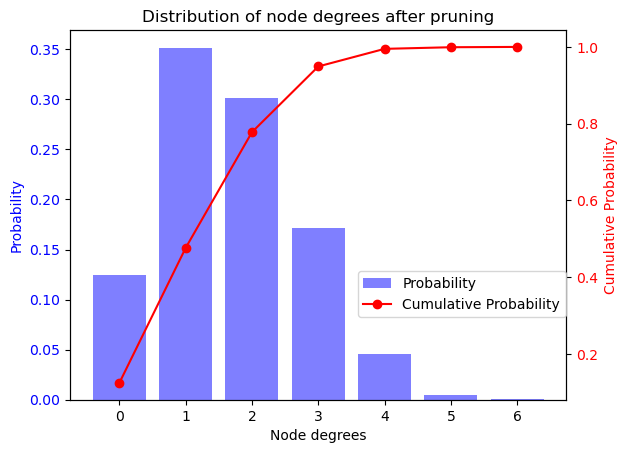

In [9]:
fig, ax1 = plt.subplots()

num_neighbour = [i for i in range(min(max_action_spaces), max(max_action_spaces)+1)]

ax1.bar(num_neighbour, prob_list, alpha=0.5, color='blue', label='Probability')
ax1.set_xlabel('Node degrees')

ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(num_neighbour)
# Step 4: Plot the cumulative probability curve
ax2 = ax1.twinx()
ax2.plot(num_neighbour, cumulative_list, color='red', marker='o', linestyle='-', label='Cumulative Probability')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_ylabel('Probability', color='blue')
ax2.set_ylabel('Cumulative Probability', color='red')
ax1.set_title('Distribution of node degrees after pruning')
fig.legend(loc=(0.57, 0.3))

plt.show()
# save as pdf
fig.savefig('after_pruning.pdf', format='pdf', dpi=1200, bbox_inches='tight')

## Node Degrees After Pruning and Padding

In [10]:
restart(sumoCmd)
max_action_spaces = []
total_actions = 0

total_missing_gain = 0
total_delay_gain = 0
step = 0
max_num_nodes = 0


while shouldContinueSim():
    step += 1
    if step > 1100:
        close()
        break
    traci.simulationStep()
    if step < 400:
        continue
    connectivity = intervehicleConnectivity(800)
    connectivity = simplify_graph(connectivity)
    # minus the diagonal
    action_spaces = connectivity.to("cpu")
    max_num_nodes = max(max_num_nodes, action_spaces.size(0))
    for i in range(action_spaces.size(0)):
        action_space = len(np.where(action_spaces[i] == 1)[0])
        if action_space != 1:
            if action_space >= 6:
                max_action_spaces.append(6)
            else:
                max_action_spaces.append(action_space)

# print each action space's proportion
cumulative = 0
cumulative_list = []
prob_list = []
for i in list(set(sorted(max_action_spaces, reverse=True))):
    prob_list.append(max_action_spaces.count(i)/len(max_action_spaces))
    cumulative += max_action_spaces.count(i)/len(max_action_spaces)
    cumulative_list.append(cumulative)

***Starting server on port 58865 ***
Loading net-file from './config/osm.net.xml.gz' ... done (107ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Simulation ended at time: 1100.00
Reason: TraCI requested termination.
Performance: 
 Duration: 1.57s
 TraCI-Duration: 1.34s
 Real time factor: 700.637
 UPS: 25970.063694
Vehicles: 
 Inserted: 89
 Running: 31
 Waiting: 0
Statistics (avg of 58):
 RouteLength: 4086.67
 Speed: 9.55
 Duration: 436.98
 WaitingTime: 14.81
 TimeLoss: 59.12
 DepartDelay: 0.47



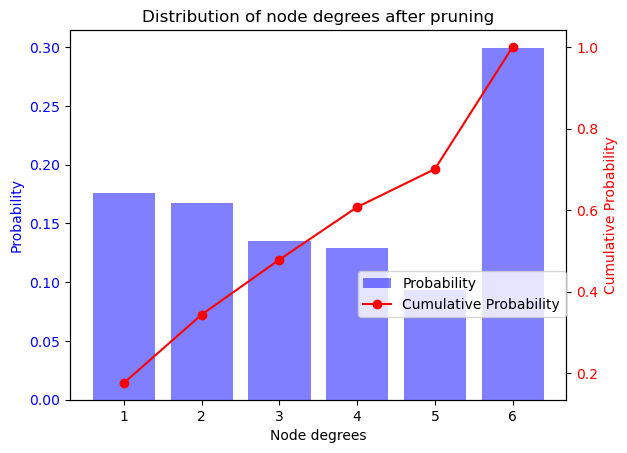

In [11]:
fig, ax1 = plt.subplots()

num_neighbour = [i for i in range(min(max_action_spaces), max(max_action_spaces)+1)]

ax1.bar(num_neighbour, prob_list, alpha=0.5, color='blue', label='Probability')
ax1.set_xlabel('Node degrees')

ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(num_neighbour)
# Step 4: Plot the cumulative probability curve
ax2 = ax1.twinx()
ax2.plot(num_neighbour, cumulative_list, color='red', marker='o', linestyle='-', label='Cumulative Probability')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_ylabel('Probability', color='blue')
ax2.set_ylabel('Cumulative Probability', color='red')
ax1.set_title('Distribution of node degrees after pruning')
fig.legend(loc=(0.57, 0.3))

plt.show()
# save as pdf
fig.savefig('after_pruning.pdf', format='pdf', dpi=1200, bbox_inches='tight')

## Test

In [37]:
adj_matrix = torch.tensor([[1, 1, 0, 0, 1, 1, 0, 0],
                            [1, 1, 1, 0, 1, 1, 0, 0],
                            [0, 1, 1, 1, 0, 0, 1, 1],
                            [0, 0, 1, 1, 0, 0, 0, 0],
                            [1, 1, 0, 0, 1, 0, 1, 0],
                            [1, 1, 0, 0, 0, 1, 0, 0],
                            [0, 0, 1, 0, 1, 0, 1, 0],
                            [0, 0, 1, 0, 0, 0, 0, 1]])
action_spaces = simplify_graph(adj_matrix)
n_hop_matrix = bfs_distance(action_spaces)

max_action_spaces = []
for i in range(action_spaces.size(0)):
    non_zero_indices = np.where(action_spaces[i] == 1)[0]
    two_hop_neighbours = np.where(n_hop_matrix[i] == 2)[0]
    two_hop_neighbours_mask = (n_hop_matrix[i] == 2).type(torch.int)
    # direct neighbours connectivities with two hop neighbours
    neighbour_dict = {}
    for neighbour_index in non_zero_indices:
        neighbour_dict[neighbour_index] = two_hop_neighbours[np.where(adj_matrix[neighbour_index][two_hop_neighbours] == 1)[0]]
    # sort by the number of two hop neighbours
    neighbour_dict = dict(sorted(neighbour_dict.items(), key=lambda item: len(item[1]), reverse=True))
    action_space = 0
    to_remove_indices = []
    for neighbour_index, two_hop_neighbours_indices in neighbour_dict.items():
        mask_sum_before = torch.sum(two_hop_neighbours_mask)
        two_hop_neighbours_mask[two_hop_neighbours_indices] = 0
        mask_sum_after = torch.sum(two_hop_neighbours_mask)
        if mask_sum_after < mask_sum_before:
            action_space += 1
        else:
            to_remove_indices.append(neighbour_index)
    cur_adj_matrix = np.delete(adj_matrix, to_remove_indices, axis=0)
    cur_adj_matrix = np.delete(cur_adj_matrix, to_remove_indices, axis=1)
    print(action_space)
    print(cur_adj_matrix)
    # remove
    max_action_spaces.append(action_space)

2
tensor([[1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 0],
        [1, 1, 0, 0, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 1]])
1
tensor([[1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1]])
1
tensor([[1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 0, 0],
        [1, 1, 0, 1, 0],
        [1, 1, 0, 0, 1]])
1
tensor([[1, 1, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1]])
1
tensor([[1, 1, 0, 1, 1, 0],
        [1, 1, 1, 0, 0, 1],
        [0, 1, 1, 0, 0, 0],
        [1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 1]])
1
tensor([[1, 1, 0, 1, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 1],
        [0, 1,